In [1]:
import torch
import numpy as np
import pandas as pd
import librosa as lr
import soundfile as sf
import matplotlib.pyplot as plt

from librosa import display as lrd
import IPython.display as ipd

from torch.utils.data import DataLoader, ConcatDataset, random_split
from asteroid.data import TimitDataset, TimitLegacyDataset
from asteroid.data.utils import CachedWavSet
from tqdm import tqdm

from torch import optim
from pytorch_lightning import Trainer, loggers as pl_loggers
from asteroid_filterbanks.transforms import mag
from asteroid.engine import System, UNetGAN

from asteroid import DCUNet, DCCRNet
from asteroid.losses import singlesrc_neg_sisdr

from asteroid.data.utils import find_audio_files
from asteroid.utils.notebook_utils import show_wav

%load_ext autoreload
%autoreload 2

In [2]:
TIMIT_CACHE_DIR = '/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid2'
TIMIT_DIR_8kHZ  = '/import/vision-eddydata/dm005_tmp/TIMIT_8kHZ'
SAMPLE_RATE     = 8000

In [3]:
noises = CachedWavSet('../../../datasets/noises-test-drones', sample_rate=SAMPLE_RATE, precache=True, with_path=True)

Precaching audio: 100%|██████████| 2/2 [00:00<00:00, 113.78it/s]


In [4]:
test_snrs = [-30, -25, -20, -15, -10, -5, 0]
test_sets = {}

i = 0
for snr in tqdm(test_snrs, 'Load datasets'):
    test_sets[snr] = TimitLegacyDataset(
        TIMIT_DIR_8kHZ, noises, sample_rate=SAMPLE_RATE,
        cache_dir=TIMIT_CACHE_DIR, snr=snr, dset_name='test-drones',
        subset='test', random_seed=68 + i, with_path=True)
    i += 1

Load datasets: 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


In [5]:
dcunet20 = DCUNet.from_pretrained(torch.load('dcunet_20_proper_v1.pt'))
dcunet20_rand = DCUNet.from_pretrained(torch.load('dcunet_20_random_v1.pt'))
dcunet20_rand_v2 = DCUNet.from_pretrained(torch.load('dcunet_20_random_v2.pt'))
dccrn_rand_v1 = DCCRNet.from_pretrained(torch.load('dccrn_random_v1.pt'))

In [6]:
mix, clean, path = test_sets[-20][0]
print(path)

/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid2/-20db/data/TEST/DR4/MGMM0/SX139.WAV.n121.wav


In [12]:
x1, _ = lr.load('x1.wav', sr=8000)

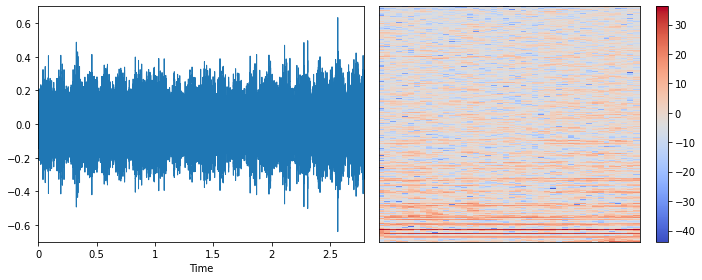

In [11]:
show_wav(mix)

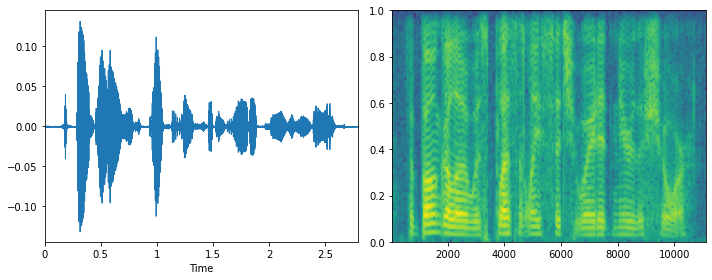

In [59]:
show_wav(clean)

DCUNET-20 (random training, v2)


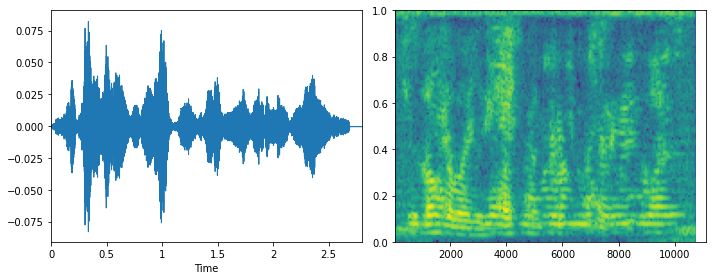

In [60]:
print('DCUNET-20 (random training, v2)')
show_wav(dcunet20_rand_v2(mix).flatten())

DCCRN (random training)


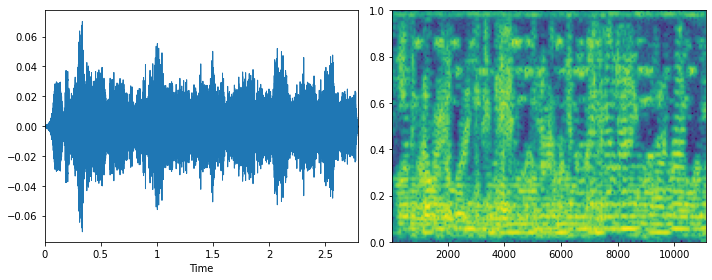

In [61]:
print('DCCRN (random training)')
show_wav(dccrn_rand_v1(mix).flatten())

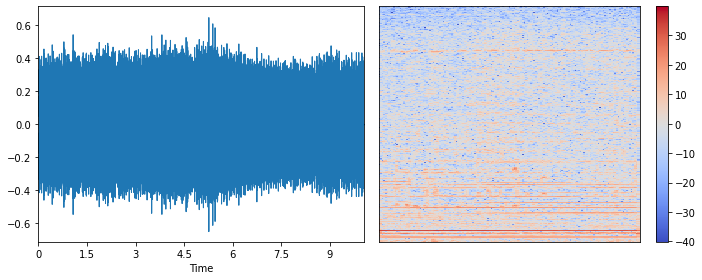

In [13]:
show_wav(x1)

In [15]:
x1_enh = dcunet20_rand_v2(torch.from_numpy(x1)).flatten().detach().numpy()

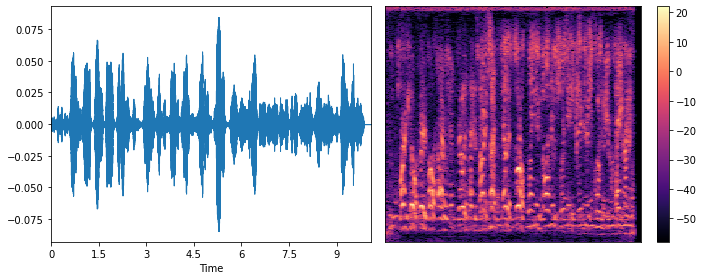

In [16]:
show_wav(x1_enh)

In [21]:
sf.write(file='x1_enh.wav', data=x1_enh, samplerate=8000)

In [40]:
from pathlib import PurePath
import os
import soundfile as sf

def enhance_test(model, test_sets, model_name):
    model = model.cuda()
    
    for snr, test_set in test_sets.items():
        print(f'SNR: {snr}db')
        common_folder = PurePath(f'/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid2/{snr}db/data/TEST')
        enh_folder = PurePath(f'/import/vision-eddydata/dm005_tmp/workspace_8kHz/enh_wavs/test/{model_name}/{snr}db')
        loader = DataLoader(test_set, num_workers=10)

        for mix, clean, path in tqdm(loader, 'Enhancing audio'):
            mix = mix.cuda()
            enh = model(mix).detach().flatten().cpu().numpy()
            rel_path = PurePath(path[0]).relative_to(common_folder)
            out_path = (enh_folder / rel_path).with_suffix('.enh.wav')
            os.makedirs(out_path.parent, exist_ok=True)
            sf.write(file=str(out_path), data=enh, samplerate=8000)

In [21]:
#enhance_test(dcunet20, test_sets, 'dcunet-20-v1')

In [23]:
#enhance_test(dcunet20_rand, test_sets, 'dcunet-20-rand-v1')

In [24]:
#enhance_test(dcunet20_rand_v2, test_sets, 'dcunet-20-rand-v2')

Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -30db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -25db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -20db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -15db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -10db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -5db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: 0db


Enhancing audio: 100%|██████████| 3360/3360 [01:58<00:00, 28.39it/s]


In [41]:
enhance_test(dccrn_rand_v1, test_sets, 'dccrn-rand-v1')

Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -30db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -25db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -20db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -15db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -10db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -5db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: 0db


Enhancing audio: 100%|██████████| 3360/3360 [03:37<00:00, 15.42it/s]
